# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# Preprocessing 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set()

* Loading Data from sql database. Ignored neutral reviews that is score=3. And data is sorted according to time.

In [2]:
import sqlite3

conn = sqlite3.connect('Data/database.sqlite')

data = pd.read_sql_query("select * from Reviews where Score !=3 order by Time", conn)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


### Deduplication


* Same review from a user to a product in different time indicates duplicate data.
* Removed data that has same product ID, user id, score, text values.

In [3]:
# removing duplicates
data = data.drop_duplicates(subset={'ProductId', 'UserId', 'Score', 
                            'Text'}, keep='first')

### Data Cleaning

* Removed html tags, punctuations from each sentence.
* Each word is lowercased and removed stop words(a, an, the....).
* Considered score 1 and 2 as negative review and scores 4 and 5 are considered as positive review.
* For negative review '0' as label and for positive review '1' as label.

In [4]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

snow = SnowballStemmer('english')
pre_processed = []

i = 0
N = len(data['Text'])
for sentence in data['Text']:    
    sentence = str(sentence)
    sentence = sentence.lower()
    clnr = re.compile('<.*?>') # for cleaning html tags
    sentence = re.sub(clnr, ' ', sentence)
    sentence = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]', r' ', sentence) 
    
    words = [snow.stem(word) for word in sentence.split() \
             if word not in stopwords.words('english')]
    final_sentence = ''
    for word in words:
        final_sentence = final_sentence + word + ' '
    pre_processed.append(final_sentence)
    print("{0:.2f} %".format(i/N*100), end='\r')
    i += 1

data['Text'] = pre_processed

In [5]:
sentiment = []

for scr in data['Score']:
    if scr < 3:
        sentiment.append(0)
    else:
        sentiment.append(1)
data['Sentiment'] = sentiment

In [2]:
# loading pre processed data from hard disk
import pickle

with open('Saved/PreProcessed.pkl', 'rb') as f:
    data = pickle.load(f)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,witti littl book make son laugh loud recit car...,1
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,rememb see show air televis year ago child sis...,1
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,beetlejuic well written movi everyth excel act...,1
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,twist rumplestiskin captur film star michael k...,1
4,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,twist rumplestiskin captur film star michael k...,1


### Data Segmentation

* First 100k review taken into consideration.
* Then data is divided in 70-30 ratio for training and testing purposes.
* Data is divided according to time.

In [3]:
te = int(10000 * 7)
X_train = data['Text'][0:te]
Y_train = data['Sentiment'][0:te]
X_test = data['Text'][te:100000]
Y_test = data['Sentiment'][te:100000]

# Bag of Words

* Trained bag of words by using training data. Transformed training and testing data to numerical vectors.
* Considered only top most 2000 important words.
* Each sentence is converted into a vector of size 2000.

In [4]:
# Training Bag of words
from sklearn.feature_extraction.text import CountVectorizer

bow_model = CountVectorizer(max_features=2000, dtype="float")
bow_train = bow_model.fit_transform(X_train)
bow_test = bow_model.transform(X_test)

## Logistic Regression

* Training Logistic Regression using LogisticRegression from sklearn.linear_model module.
* Trained on bag of words data.

#### Grid Search

* Technique for searching for optimal depth.

In [5]:
# searching for best hyperparameter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

parameters = {'penalty':['l1', 'l2'],
              'C':[0.001, 0.01, 0.1, 1, 10]}
classifier_ = LogisticRegression(class_weight='balanced')

search_hyp = GridSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [6]:
search_hyp.fit(bow_train, Y_train)
print("best parameters: ")
print(search_hyp.best_params_)
classifier = search_hyp.best_estimator_

best parameters: 
{'C': 1, 'penalty': 'l2'}


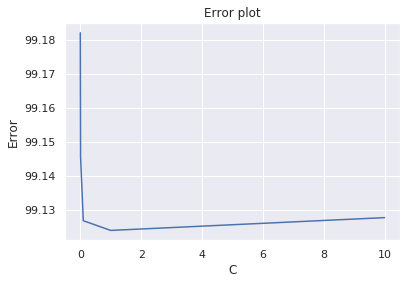

In [7]:
scores = search_hyp.cv_results_['mean_test_score']
test_errorsC = []
for i in range(0, len(scores), 2):
    best_error = 100 - \
                sorted([scores[i], scores[i+1]])[1]
    test_errorsC.append(best_error)
    
plt.plot(parameters['C'], test_errorsC)
plt.title('Error plot')
plt.xlabel('C')
plt.ylabel('Error') 
plt.show()

In [8]:
# performence metrics

from sklearn import metrics
pred = classifier.predict(bow_test)

tr_score = classifier.score(bow_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [9]:
from prettytable import PrettyTable
tb1 = PrettyTable()
tb1.field_names = ['Search Algo', 'Regularizor', 'C', 'Train accuracy', 
                  'Test accuracy', 'Precision', 'Recall', 'f1-score'] 
tb1.add_row(['Grid Search', search_hyp.best_params_['penalty'], 
             search_hyp.best_params_['C'], round(tr_score, 2), 
             round(accuracy, 2), round(pre, 2), round(rec, 2), 
             round(f1, 2)])

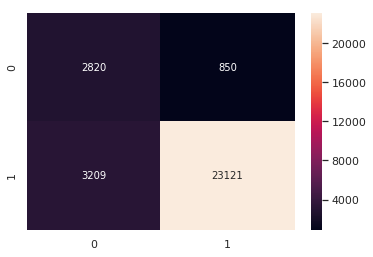

In [10]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

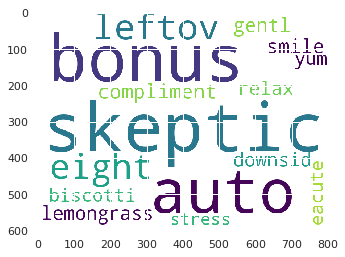

In [11]:
from wordcloud import WordCloud

te = {}
indices = np.array(list(map(abs, classifier.coef_))).argsort()[0][1970:2000]
indices = indices.tolist()
for ind_ in indices:
    for word in bow_model.vocabulary_:
        if bow_model.vocabulary_[word] == ind_:
            te[word] = classifier.coef_[0][ind_]
    
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white').generate_from_frequencies(te)
plt.imshow(wordcloud)
plt.show()

### Random Search

* Searching randomly for best depth.

In [12]:
# searching for best hyperparameter
from sklearn.model_selection import RandomizedSearchCV
C = np.random.uniform(low=0.001, high=10, size=50)

parameters = {'penalty':['l1', 'l2'],
              'C':C}
classifier_ = LogisticRegression(class_weight='balanced')

search_hyp = RandomizedSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [13]:
search_hyp.fit(bow_train, Y_train)
print("best parameters: ")
print(search_hyp.best_params_)
classifier = search_hyp.best_estimator_

best parameters: 
{'C': 1.520177165720327, 'penalty': 'l2'}


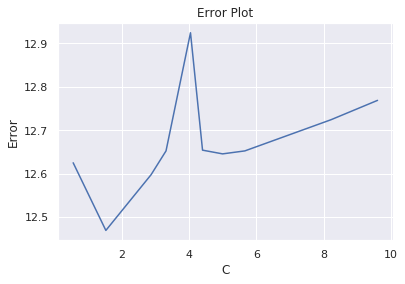

In [14]:
te = []
for i in range(10):
    te.append(search_hyp.cv_results_['params'][i]['C'])
indices = np.argsort(te).tolist()
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

temp1 = []
temp2 = []
for ind in indices:
    temp1.append(te[ind])
    temp2.append(test_errors[ind])
    
plt.plot(temp1, temp2)
plt.title('Error Plot')
plt.xlabel("C")
plt.ylabel("Error")
plt.show()

In [15]:
pred = classifier.predict(bow_test)

tr_score = classifier.score(bow_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [16]:
tb1.add_row(['Random Search', search_hyp.best_params_['penalty'], 
             round(search_hyp.best_params_['C'], 3), round(tr_score, 2), 
             round(accuracy, 2), round(pre, 2), round(rec, 2), 
             round(f1, 2)])

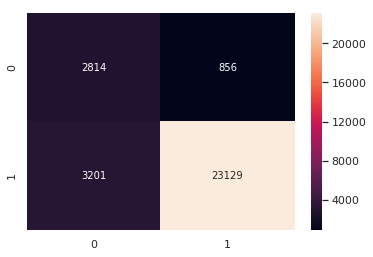

In [17]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show() 

In [18]:
print(tb1)

+---------------+-------------+------+----------------+---------------+-----------+--------+----------+
|  Search Algo  | Regularizor |  C   | Train accuracy | Test accuracy | Precision | Recall | f1-score |
+---------------+-------------+------+----------------+---------------+-----------+--------+----------+
|  Grid Search  |      l2     |  1   |      0.91      |      0.86     |    0.96   |  0.88  |   0.92   |
| Random Search |      l2     | 1.52 |      0.91      |      0.86     |    0.96   |  0.88  |   0.92   |
+---------------+-------------+------+----------------+---------------+-----------+--------+----------+


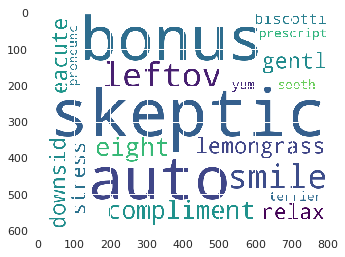

In [19]:
from wordcloud import WordCloud

te = {}
indices = np.array(list(map(abs, classifier.coef_[0]))).argsort()[1970:2000]
indices = indices.tolist()
for ind_ in indices:
    for word in bow_model.vocabulary_:
        if bow_model.vocabulary_[word] == ind_:
            te[word] = classifier.coef_[0][ind_]
    
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white').generate_from_frequencies(te)
plt.imshow(wordcloud)
plt.show()

In [35]:
def cal_percChange(array1, array2):
    change = 0
    for i in range(array1.shape[0]):
        if array1[i] != array2[i]:
            change += 1
    p_change = (change / array1.shape[0]) * 100
    return p_change
            
# pertubation test
from sklearn.metrics import mean_absolute_error
prev_weights = classifier.coef_[0]

noise_data = bow_train.todense()
noise_data[878] += 0.01
classifier = LogisticRegression(penalty='l2', class_weight='balanced',
                                C=search_hyp.best_params_['C']) 
classifier.fit(noise_data, Y_train)
new_weights = classifier.coef_[0]
perc_change = cal_percChange(prev_weights, new_weights)
print('percentage change of weights: ', perc_change)

percentage change of weights:  0.0


- There is 0% of change. So no multicollinearity exists.

#### sparsity check

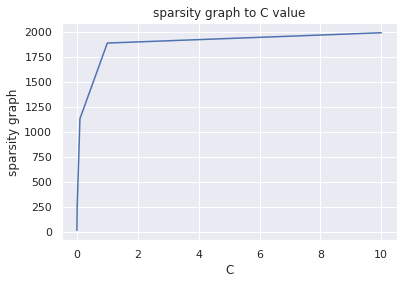

In [36]:
C = [0.001, 0.01, 0.1, 1, 10]
sparsity = []
for c in C:
    classifier = LogisticRegression(C=c, penalty='l1', class_weight='balanced')
    classifier.fit(bow_train, Y_train)
    weights = classifier.coef_[0] 
    sparsity.append(np.count_nonzero(weights))
    
### plotting sparsity to C valuse
plt.plot(C, sparsity)
plt.title('sparsity graph to C value')
plt.xlabel('C')
plt.ylabel('sparsity graph')
plt.show()

* As we can observe that as C value increases sparsity increases.

# Tf-Idf

* Trained tf-idf by using training data. Transformed training and testing data to numerical vectors.
* TfidfVectorizer from sklearn is used.
* Considered only top most 2000 important words.
* Each sentence is converted into a vector of size 2000.

In [40]:
# Training tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(max_features=2000)
tfidf_train = tfidf_model.fit_transform(X_train)
tfidf_test = tfidf_model.transform(X_test)

## Logistic Regression

* Training Logistic Regression using LogisticRegression from sklearn.linear_model module.
* Trained on Tf-idf data.

### L1 - regularizor
* Using l1 type regularization term as penalty for loss in logistic Regression.

#### Grid Search

* Technique for searching for optimal depth.

In [41]:
# searching for best hyperparameter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

parameters = {'C':[0.001, 0.01, 0.1, 1, 10]}
classifier_ = LogisticRegression(penalty='l1', class_weight='balanced')

search_hyp = GridSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [42]:
search_hyp.fit(tfidf_train, Y_train)
search_hyp.best_params_

{'C': 10}

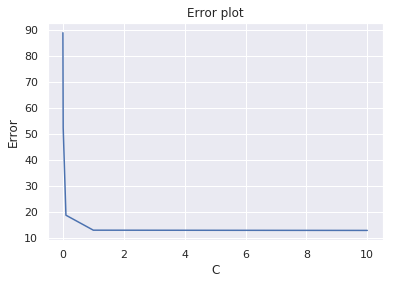

In [43]:
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

plt.plot(parameters['C'], test_errors)
plt.title('Error plot')
plt.xlabel('C')
plt.ylabel('Error') 
plt.show()

Optimal C is 10.

In [44]:
# training final model
classifier = LogisticRegression(penalty='l1', class_weight='balanced',
                                    C=search_hyp.best_params_['C'])
classifier.fit(tfidf_train, Y_train)

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [45]:
# performence metrics

from sklearn import metrics
pred = classifier.predict(tfidf_test)

tr_score = classifier.score(tfidf_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [46]:
from prettytable import PrettyTable
tb2 = PrettyTable()
tb2.field_names = ['Search Algo', 'Regularizor', 'C', 'Train accuracy', 
                  'Test accuracy', 'Precision', 'Recall', 'f1-score'] 
tb2.add_row(['Grid Search', 'L1', search_hyp.best_params_['C'], 
            round(tr_score, 2), round(accuracy, 2), round(pre, 2), 
            round(rec, 2), round(f1, 2)])

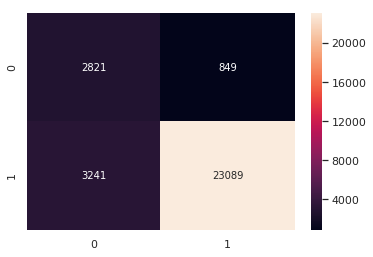

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

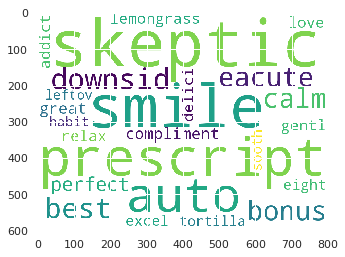

In [48]:
from wordcloud import WordCloud

te = {}
indices = np.array(list(map(abs, classifier.coef_))).argsort()[0][1970:2000]
indices = indices.tolist()
for ind_ in indices:
    for word in tfidf_model.vocabulary_:
        if tfidf_model.vocabulary_[word] == ind_:
            te[word] = classifier.coef_[0][ind_]
    
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white').generate_from_frequencies(te)
plt.imshow(wordcloud)
plt.show()

### Random Search

* Searching randomly for best depth.

In [73]:
# searching for best hyperparameter
from sklearn.model_selection import RandomizedSearchCV
C = np.random.uniform(low=0.001, high=10, size=50)

parameters = {'C':C}
classifier_ = LogisticRegression(penalty='l1', class_weight='balanced')

search_hyp = RandomizedSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [74]:
search_hyp.fit(tfidf_train, Y_train)
search_hyp.best_params_

{'C': 4.6989205350556515}

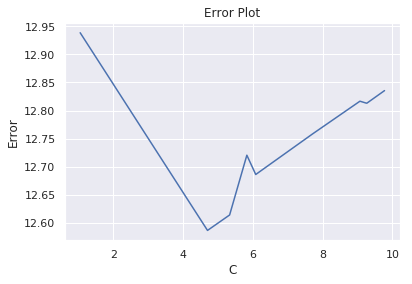

In [75]:
te = []
for i in range(10):
    te.append(search_hyp.cv_results_['params'][i]['C'])
indices = np.argsort(te).tolist()
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

temp1 = []
temp2 = []
for ind in indices:
    temp1.append(te[ind])
    temp2.append(test_errors[ind])
    
plt.plot(temp1, temp2)
plt.title('Error Plot')
plt.xlabel("C")
plt.ylabel("Error")
plt.show()

Optimal C is 4.69.

In [76]:
# training final model
classifier = LogisticRegression(penalty='l1', class_weight='balanced',
                                C=search_hyp.best_params_['C']) 
classifier.fit(tfidf_train, Y_train)

LogisticRegression(C=4.6989205350556515, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [77]:
pred = classifier.predict(tfidf_test)

tr_score = classifier.score(tfidf_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [78]:
tb2.add_row(['Random Search', 'L1', round(search_hyp.best_params_['C'], 3), 
            round(tr_score, 2), round(accuracy, 2), round(pre, 2), 
            round(rec, 2), round(f1, 2)]) 

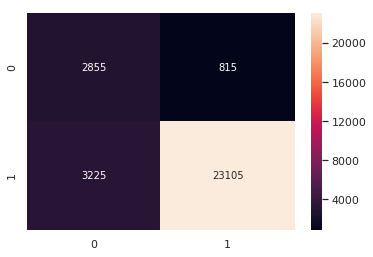

In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

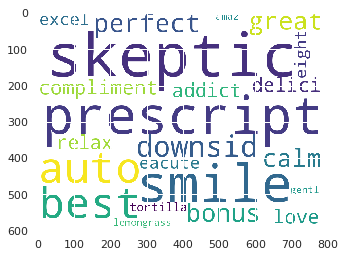

In [80]:
from wordcloud import WordCloud

te = {}
indices = np.array(list(map(abs, classifier.coef_[0]))).argsort()[1970:2000]
indices = indices.tolist()
for ind_ in indices:
    for word in tfidf_model.vocabulary_:
        if tfidf_model.vocabulary_[word] == ind_:
            te[word] = classifier.coef_[0][ind_]
    
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white').generate_from_frequencies(te)
plt.imshow(wordcloud)
plt.show()

In [83]:
# pertubation test

from sklearn.metrics import mean_absolute_error
prev_weights = classifier.coef_[0]

noise_data = tfidf_train.todense()
noise_data[878] += 0.01
classifier = LogisticRegression(penalty='l1', class_weight='balanced',
                                C=search_hyp.best_params_['C']) 
classifier.fit(noise_data, Y_train)
new_weights = classifier.coef_[0]
change = cal_percChange(prev_weights, new_weights)
print('percentage change of weights: ', change)

percentage change of weights:  95.19999999999999


- Percentage change of weights is large. So multicollinearity exists.

### L2 - regularizor
* Using l2 type regularization term as penalty for loss in logistic Regression.

#### Grid Search

* Technique for searching for optimal depth.

In [84]:
# searching for best hyperparameter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

parameters = {'C':[0.001, 0.01, 0.1, 1, 10]}
classifier_ = LogisticRegression(penalty='l2', class_weight='balanced')

search_hyp = GridSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [85]:
search_hyp.fit(tfidf_train, Y_train)
search_hyp.best_params_

{'C': 10}

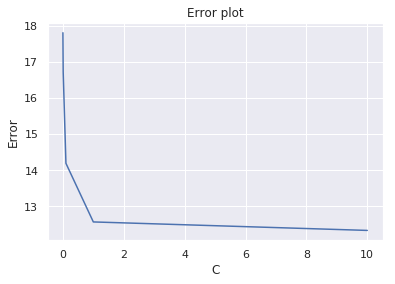

In [86]:
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

plt.plot(parameters['C'], test_errors)
plt.title('Error plot')
plt.xlabel('C')
plt.ylabel('Error') 
plt.show()

Optimal C is 10.

In [87]:
# training final model
classifier = LogisticRegression(penalty='l2', class_weight='balanced',
                                    C=search_hyp.best_params_['C'])
classifier.fit(tfidf_train, Y_train)

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [88]:
# performence metrics

from sklearn import metrics
pred = classifier.predict(tfidf_test)

tr_score = classifier.score(tfidf_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [89]:
tb2.add_row(['Grid Search', 'L2', search_hyp.best_params_['C'], 
            round(tr_score, 2), round(accuracy, 2), round(pre, 2), 
            round(rec, 2), round(f1, 2)])

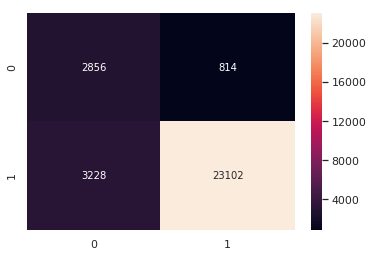

In [90]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

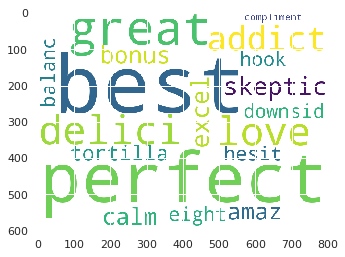

In [91]:
from wordcloud import WordCloud

te = {}
indices = np.array(list(map(abs, classifier.coef_))).argsort()[0][1970:2000]
indices = indices.tolist()
for ind_ in indices:
    for word in tfidf_model.vocabulary_:
        if tfidf_model.vocabulary_[word] == ind_:
            te[word] = classifier.coef_[0][ind_]
    
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white').generate_from_frequencies(te)
plt.imshow(wordcloud)
plt.show()

### Random Search

* Searching randomly for best depth.

In [92]:
# searching for best hyperparameter
from sklearn.model_selection import RandomizedSearchCV
C = np.random.uniform(low=0.001, high=10, size=50)

parameters = {'C':C}
classifier_ = LogisticRegression(penalty='l2', class_weight='balanced')

search_hyp = RandomizedSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [93]:
search_hyp.fit(bow_train, Y_train)
search_hyp.best_params_

{'C': 0.5015477301865224}

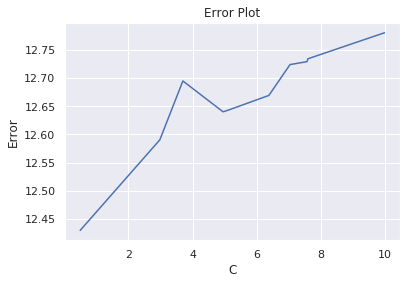

In [94]:
te = []
for i in range(10):
    te.append(search_hyp.cv_results_['params'][i]['C'])
indices = np.argsort(te).tolist()
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

temp1 = []
temp2 = []
for ind in indices:
    temp1.append(te[ind])
    temp2.append(test_errors[ind])
    
plt.plot(temp1, temp2)
plt.title('Error Plot')
plt.xlabel("C")
plt.ylabel("Error")
plt.show()

Optimal C is 0.501.

In [95]:
# training final model
classifier = LogisticRegression(penalty='l2', class_weight='balanced',
                                C=search_hyp.best_params_['C']) 
classifier.fit(tfidf_train, Y_train)

LogisticRegression(C=0.5015477301865224, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [96]:
pred = classifier.predict(tfidf_test)

tr_score = classifier.score(tfidf_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [97]:
tb2.add_row(['Random Search', 'L2', round(search_hyp.best_params_['C'], 3), 
            round(tr_score, 2), round(accuracy, 2), round(pre, 2), 
            round(rec, 2), round(f1, 2)]) 

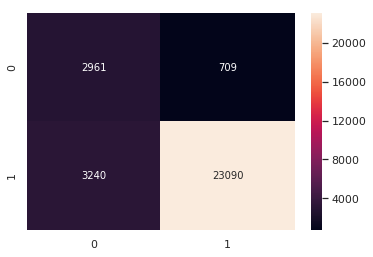

In [98]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

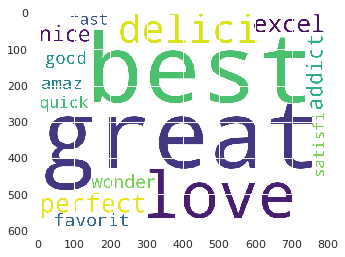

In [99]:
from wordcloud import WordCloud

te = {}
indices = np.array(list(map(abs, classifier.coef_[0]))).argsort()[1970:2000]
indices = indices.tolist()
for ind_ in indices:
    for word in tfidf_model.vocabulary_:
        if tfidf_model.vocabulary_[word] == ind_:
            te[word] = classifier.coef_[0][ind_]
    
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white').generate_from_frequencies(te)
plt.imshow(wordcloud)
plt.show()

In [103]:
# pertubation test

from sklearn.metrics import mean_absolute_error
prev_weights = classifier.coef_[0]

noise_data = tfidf_train.todense()
noise_data[878] += 0.01
classifier = LogisticRegression(penalty='l2', class_weight='balanced',
                                C=search_hyp.best_params_['C']) 
classifier.fit(noise_data, Y_train)
new_weights = classifier.coef_[0]
change = cal_percChange(prev_weights, new_weights)
print('percentage change of weights: ', change)

percentage change of weights:  0.0


- Percentage change is zero. So no multicollinearity exists.

# Word2vec

* Trained own word2vec using gensim module. Considered words which has frequency more than 5 in whole data.
* Trained word2vec using Word2vec function from gensim.models.
* Trained for vector of size 150. And converted each word into a vector of size 150.
* Added all vectors of a sentence and divided with total number of vectors in sentence. So that we can get average word2vec value for each sentence.

In [74]:
# training word2vec on training data
from gensim.models import Word2Vec
sentences = []
for row in X_train:
    sentences.append([word for word in row.split()])

w2v = Word2Vec(sentences, min_count=5, size=150, workers=3)
avgw2v_train = []
for row in sentences:
    te = [0 for i in range(150)]
    num = 0
    for word in row:
        try:
            te += w2v[word]
            num += 1
        except:
            pass
    avgw2v_train.append(te/num)

In [75]:
# converting test data

sentences = []
for row in X_test:
    sentences.append([word for word in row.split()])

avgw2v_test = []
for row in sentences:
    te = [0 for i in range(150)]
    num = 0
    for word in row:
        try:
            te += w2v[word]
            num += 1
        except:
            pass
    avgw2v_test.append(te/num)

## Logistic Regression

* Training Logistic Regression using LogisticRegression from sklearn.linear_model module.
* Trained on Average word2vec data.

### L1 - regularizor
* Using l1 type regularization term as penalty for loss in logistic Regression.

#### Grid Search

* Technique for searching for optimal depth.

In [76]:
# searching for best hyperparameter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

parameters = {'C':[0.001, 0.01, 0.1, 1, 10]}
classifier_ = LogisticRegression(penalty='l1', class_weight='balanced')

search_hyp = GridSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [77]:
search_hyp.fit(avgw2v_train, Y_train)
search_hyp.best_params_

{'C': 10}

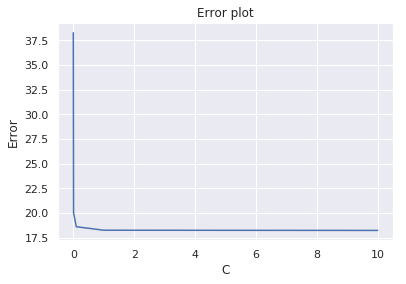

In [78]:
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

plt.plot(parameters['C'], test_errors)
plt.title('Error plot')
plt.xlabel('C')
plt.ylabel('Error') 
plt.show()

Optimal C is 10.

In [79]:
# training final model
classifier = LogisticRegression(penalty='l1', class_weight='balanced',
                                    C=search_hyp.best_params_['C'])
classifier.fit(avgw2v_train, Y_train)

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [80]:
# performence metrics

from sklearn import metrics
pred = classifier.predict(avgw2v_test)

tr_score = classifier.score(avgw2v_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [81]:
from prettytable import PrettyTable
tb3 = PrettyTable()
tb3.field_names = ['Search Algo', 'Regularizor', 'C', 'Train accuracy', 
                  'Test accuracy', 'Precision', 'Recall', 'f1-score'] 
tb3.add_row(['Grid Search', 'L1', search_hyp.best_params_['C'], 
            round(tr_score, 2), round(accuracy, 2), round(pre, 2), 
            round(rec, 2), round(f1, 2)])

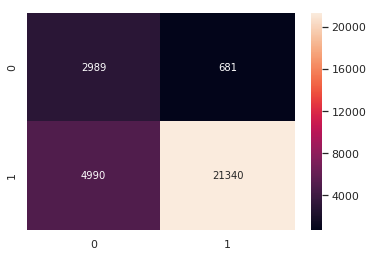

In [82]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Random Search

* Searching randomly for best depth.

In [83]:
# searching for best hyperparameter
from sklearn.model_selection import RandomizedSearchCV
C = np.random.uniform(low=0.001, high=10, size=50)

parameters = {'C':C}
classifier_ = LogisticRegression(penalty='l1', class_weight='balanced')

search_hyp = RandomizedSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [85]:
search_hyp.fit(avgw2v_train, Y_train)
search_hyp.best_params_

{'C': 8.60632059226799}

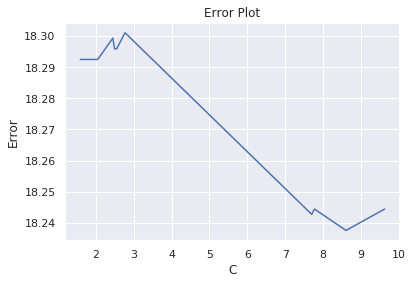

In [86]:
te = []
for i in range(10):
    te.append(search_hyp.cv_results_['params'][i]['C'])
indices = np.argsort(te).tolist()
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

temp1 = []
temp2 = []
for ind in indices:
    temp1.append(te[ind])
    temp2.append(test_errors[ind])
    
plt.plot(temp1, temp2)
plt.title('Error Plot')
plt.xlabel("C")
plt.ylabel("Error")
plt.show()

Optimal C is 5.192.

In [87]:
# training final model
classifier = LogisticRegression(penalty='l1', class_weight='balanced',
                                C=search_hyp.best_params_['C']) 
classifier.fit(avgw2v_train, Y_train)

LogisticRegression(C=8.60632059226799, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [88]:
pred = classifier.predict(avgw2v_test)

tr_score = classifier.score(avgw2v_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [89]:
tb3.add_row(['Random Search', 'L1', round(search_hyp.best_params_['C'], 3), 
            round(tr_score, 2), round(accuracy, 2), round(pre, 2), 
            round(rec, 2), round(f1, 2)]) 

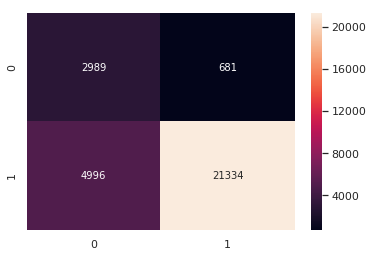

In [90]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### L2 - regularizor
* Using l2 type regularization term as penalty for loss in logistic Regression.

#### Grid Search

* Technique for searching for optimal depth.

In [92]:
# searching for best hyperparameter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

parameters = {'C':[0.001, 0.01, 0.1, 1, 10]}
classifier_ = LogisticRegression(penalty='l2', class_weight='balanced')

search_hyp = GridSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [93]:
search_hyp.fit(avgw2v_train, Y_train)
search_hyp.best_params_

{'C': 10}

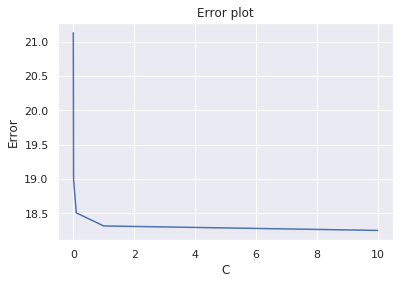

In [94]:
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

plt.plot(parameters['C'], test_errors)
plt.title('Error plot')
plt.xlabel('C')
plt.ylabel('Error') 
plt.show()

Optimal C is 10.

In [95]:
# training final model
classifier = LogisticRegression(penalty='l2', class_weight='balanced',
                                    C=search_hyp.best_params_['C'])
classifier.fit(avgw2v_train, Y_train)

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [96]:
# performence metrics

from sklearn import metrics
pred = classifier.predict(avgw2v_test)

tr_score = classifier.score(avgw2v_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [97]:
tb3.add_row(['Grid Search', 'L2', search_hyp.best_params_['C'], 
            round(tr_score, 2), round(accuracy, 2), round(pre, 2), 
            round(rec, 2), round(f1, 2)])

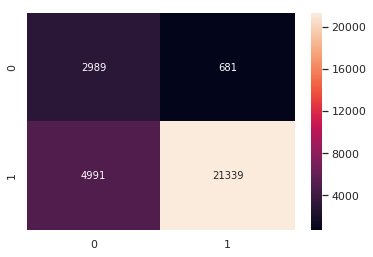

In [98]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Random Search

* Searching randomly for best depth.

In [99]:
# searching for best hyperparameter
from sklearn.model_selection import RandomizedSearchCV
C = np.random.uniform(low=0.001, high=10, size=50)

parameters = {'C':C}
classifier_ = LogisticRegression(penalty='l2', class_weight='balanced')

search_hyp = RandomizedSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [100]:
search_hyp.fit(avgw2v_train, Y_train) 
search_hyp.best_params_

{'C': 8.636128078187916}

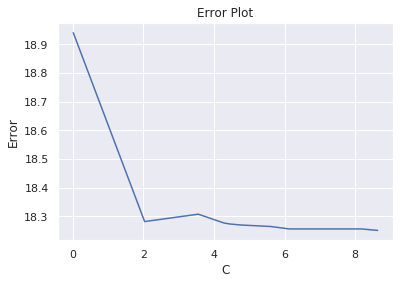

In [101]:
te = []
for i in range(10):
    te.append(search_hyp.cv_results_['params'][i]['C'])
indices = np.argsort(te).tolist()
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

temp1 = []
temp2 = []
for ind in indices:
    temp1.append(te[ind])
    temp2.append(test_errors[ind])
    
plt.plot(temp1, temp2)
plt.title('Error Plot')
plt.xlabel("C")
plt.ylabel("Error")
plt.show()

Optimal C is 0.074.

In [102]:
# training final model
classifier = LogisticRegression(penalty='l2', class_weight='balanced',
                                C=search_hyp.best_params_['C']) 
classifier.fit(avgw2v_train, Y_train)

LogisticRegression(C=8.636128078187916, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [103]:
pred = classifier.predict(avgw2v_test)

tr_score = classifier.score(avgw2v_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [104]:
tb3.add_row(['Random Search', 'L2', round(search_hyp.best_params_['C'], 3), 
            round(tr_score, 2), round(accuracy, 2), round(pre, 2), 
            round(rec, 2), round(f1, 2)]) 

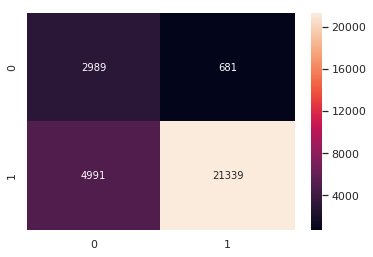

In [105]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# Tf-IDF word2vec

* Using pre-trained tf-idf vectors and word2vec of size 150.
* Multiplying each word's word2vec vector and tf-idf value of that word in respected sentence.
* Executing above step for each word in a sentence and took sum of values of all words in a sentence.
* And this sum is divided by sum of tf-idf values of all words in sentences. Finally gives tf-idf word2vec values of size 150 for each sentence.

In [110]:
tfidf_train = tfidf_train.toarray()
tfidf_test = tfidf_test.toarray()

In [111]:
sentences = []
for row in X_train:
    sentences.append([word for word in row.split()])

tfidfw2v_train = []
i = 0
for row in sentences:
    te = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tfidf_train[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    num = 0
    tf_idf_sum = 0
    for word in row:
        try:
            num += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[num-1]
            te += (temp_tfidf[num-1] * w2v[word])
        except:
            pass
    try: # avoiding divide by zero
        te = (float)(1/tf_idf_sum) * te
    except:
        pass
    tfidfw2v_train.append(te)
    i = i + 1

In [112]:
sentences = []
for row in X_test:
    sentences.append([word for word in row.split()])

tfidfw2v_test = []
i = 0
for row in sentences:
    te = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tfidf_test[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    num = 0
    tf_idf_sum = 0
    for word in row:
        try:
            num += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[num-1]
            te += (temp_tfidf[num-1] * w2v[word])
        except:
            pass
    try: # avoiding divide by zero
        te = (float)(1/tf_idf_sum) * te
    except:
        pass
    tfidfw2v_test.append(te)
    i = i + 1 

## Logistic Regression

* Training Logistic Regression using LogisticRegression from sklearn.linear_model module.
* Trained on Tf-idf word2vec data.

### L1 - regularizor
* Using l1 type regularization term as penalty for loss in logistic Regression.

#### Grid Search

* Technique for searching for optimal depth.

In [113]:
# searching for best hyperparameter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

parameters = {'C':[0.001, 0.01, 0.1, 1, 10]}
classifier_ = LogisticRegression(penalty='l1', class_weight='balanced')

search_hyp = GridSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [114]:
search_hyp.fit(tfidfw2v_train, Y_train)
search_hyp.best_params_

{'C': 1}

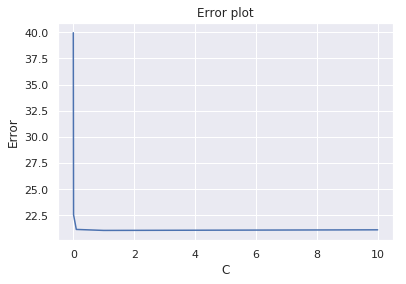

In [115]:
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

plt.plot(parameters['C'], test_errors)
plt.title('Error plot')
plt.xlabel('C')
plt.ylabel('Error') 
plt.show()

Optimal C is 1.

In [116]:
# training final model
classifier = LogisticRegression(penalty='l1', class_weight='balanced',
                                    C=search_hyp.best_params_['C'])
classifier.fit(tfidfw2v_train, Y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [117]:
# performence metrics

from sklearn import metrics
pred = classifier.predict(tfidfw2v_test)

tr_score = classifier.score(tfidfw2v_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [118]:
from prettytable import PrettyTable
tb4 = PrettyTable()
tb4.field_names = ['Search Algo', 'Regularizor', 'C', 'Train accuracy', 
                  'Test accuracy', 'Precision', 'Recall', 'f1-score'] 
tb4.add_row(['Grid Search', 'L1', search_hyp.best_params_['C'], 
            round(tr_score, 2), round(accuracy, 2), round(pre, 2), 
            round(rec, 2), round(f1, 2)])

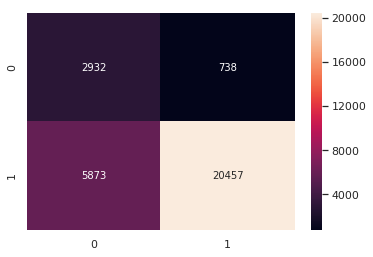

In [119]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Random Search

* Searching randomly for best depth.

In [120]:
# searching for best hyperparameter
from sklearn.model_selection import RandomizedSearchCV
C = np.random.uniform(low=0.001, high=10, size=50)

parameters = {'C':C}
classifier_ = LogisticRegression(penalty='l1', class_weight='balanced')

search_hyp = RandomizedSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [121]:
search_hyp.fit(tfidfw2v_train, Y_train)
search_hyp.best_params_

{'C': 1.1514545428996794}

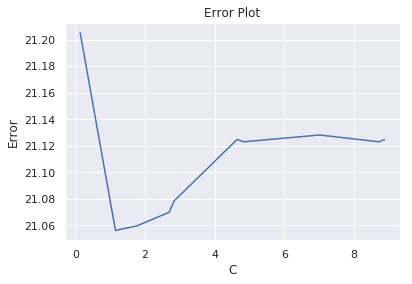

In [122]:
te = []
for i in range(10):
    te.append(search_hyp.cv_results_['params'][i]['C'])
indices = np.argsort(te).tolist()
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

temp1 = []
temp2 = []
for ind in indices:
    temp1.append(te[ind])
    temp2.append(test_errors[ind])
    
plt.plot(temp1, temp2)
plt.title('Error Plot')
plt.xlabel("C")
plt.ylabel("Error")
plt.show()

Optimal C is 1.151.

In [123]:
# training final model
classifier = LogisticRegression(penalty='l1', class_weight='balanced',
                                C=search_hyp.best_params_['C']) 
classifier.fit(tfidfw2v_train, Y_train)

LogisticRegression(C=1.1514545428996794, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [124]:
pred = classifier.predict(tfidfw2v_test)

tr_score = classifier.score(tfidfw2v_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [125]:
tb4.add_row(['Random Search', 'L1', round(search_hyp.best_params_['C'], 3), 
            round(tr_score, 2), round(accuracy, 2), round(pre, 2), 
            round(rec, 2), round(f1, 2)]) 

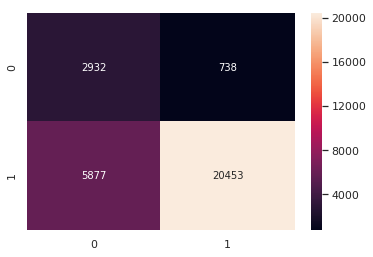

In [126]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### L2 - regularizor
* Using l2 type regularization term as penalty for loss in logistic Regression.

#### Grid Search

* Technique for searching for optimal depth.

In [128]:
# searching for best hyperparameter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

parameters = {'C':[0.001, 0.01, 0.1, 1, 10]}
classifier_ = LogisticRegression(penalty='l2', class_weight='balanced')

search_hyp = GridSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [129]:
search_hyp.fit(tfidfw2v_train, Y_train)
search_hyp.best_params_

{'C': 0.1}

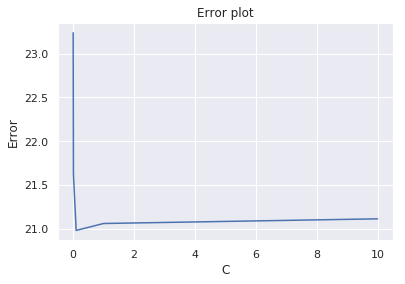

In [130]:
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

plt.plot(parameters['C'], test_errors)
plt.title('Error plot')
plt.xlabel('C')
plt.ylabel('Error') 
plt.show()

Optimal C is 0.1.

In [131]:
# training final model
classifier = LogisticRegression(penalty='l2', class_weight='balanced',
                                    C=search_hyp.best_params_['C'])
classifier.fit(tfidfw2v_train, Y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [132]:
# performence metrics

from sklearn import metrics
pred = classifier.predict(tfidfw2v_test)

tr_score = classifier.score(tfidfw2v_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [133]:
tb4.add_row(['Grid Search', 'L2', search_hyp.best_params_['C'], 
            round(tr_score, 2), round(accuracy, 2), round(pre, 2), 
            round(rec, 2), round(f1, 2)])

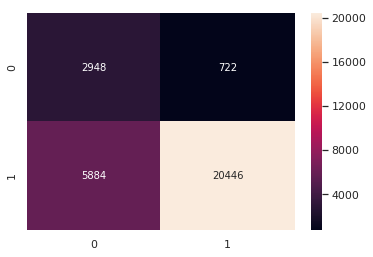

In [134]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### Random Search

* Searching randomly for best depth.

In [135]:
# searching for best hyperparameter
from sklearn.model_selection import RandomizedSearchCV
C = np.random.uniform(low=0.001, high=10, size=50)

parameters = {'C':C}
classifier_ = LogisticRegression(penalty='l2', class_weight='balanced')

search_hyp = RandomizedSearchCV(classifier_, parameters, cv=tscv, n_jobs=3)

In [136]:
search_hyp.fit(tfidfw2v_train, Y_train) 
search_hyp.best_params_

{'C': 5.3957896678474295}

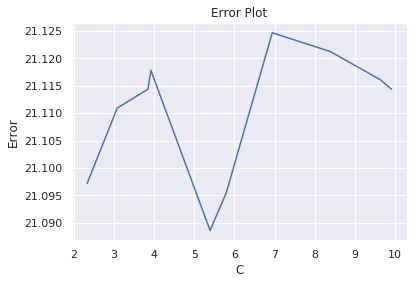

In [137]:
te = []
for i in range(10):
    te.append(search_hyp.cv_results_['params'][i]['C'])
indices = np.argsort(te).tolist()
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

temp1 = []
temp2 = []
for ind in indices:
    temp1.append(te[ind])
    temp2.append(test_errors[ind])
    
plt.plot(temp1, temp2)
plt.title('Error Plot')
plt.xlabel("C")
plt.ylabel("Error")
plt.show()

Optimal C is 5.395.

In [138]:
# training final model
classifier = LogisticRegression(penalty='l2', class_weight='balanced',
                                C=search_hyp.best_params_['C']) 
classifier.fit(tfidfw2v_train, Y_train)

LogisticRegression(C=5.3957896678474295, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [139]:
pred = classifier.predict(tfidfw2v_test)

tr_score = classifier.score(tfidfw2v_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [140]:
tb4.add_row(['Random Search', 'L2', round(search_hyp.best_params_['C'], 3), 
            round(tr_score, 2), round(accuracy, 2), round(pre, 2), 
            round(rec, 2), round(f1, 2)]) 

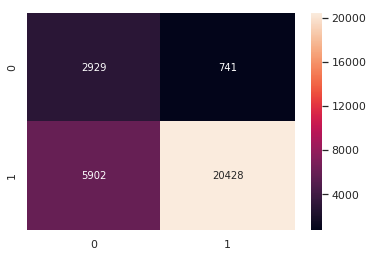

In [141]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

# Conclusion

In [107]:
print("Logistic performence with bag of words: ")
print(tb1)

Logistic performence with bag of words: 
+---------------+-------------+-------+----------------+---------------+-----------+--------+----------+
|  Search Algo  | Regularizor |   C   | Train accuracy | Test accuracy | Precision | Recall | f1-score |
+---------------+-------------+-------+----------------+---------------+-----------+--------+----------+
|  Grid Search  |      L1     |   1   |      0.9       |      0.86     |    0.96   |  0.88  |   0.92   |
| Random Search |      L1     | 0.606 |      0.9       |      0.87     |    0.96   |  0.88  |   0.92   |
|  Grid Search  |      L2     |   1   |      0.91      |      0.86     |    0.96   |  0.88  |   0.92   |
| Random Search |      L2     | 1.425 |      0.91      |      0.87     |    0.96   |  0.88  |   0.92   |
+---------------+-------------+-------+----------------+---------------+-----------+--------+----------+


In [108]:
print("Logistic performence with tf-idf: ")
print(tb2)

Logistic performence with tf-idf: 
+---------------+-------------+-------+----------------+---------------+-----------+--------+----------+
|  Search Algo  | Regularizor |   C   | Train accuracy | Test accuracy | Precision | Recall | f1-score |
+---------------+-------------+-------+----------------+---------------+-----------+--------+----------+
|  Grid Search  |      L1     |   10  |      0.9       |      0.86     |    0.96   |  0.88  |   0.92   |
| Random Search |      L1     |  4.29 |      0.9       |      0.87     |    0.97   |  0.88  |   0.92   |
|  Grid Search  |      L2     |   10  |      0.9       |      0.87     |    0.97   |  0.88  |   0.92   |
| Random Search |      L2     | 1.637 |      0.9       |      0.87     |    0.97   |  0.88  |   0.92   |
+---------------+-------------+-------+----------------+---------------+-----------+--------+----------+


In [109]:
print("Logistic peformence with average word2vec: ")
print(tb3)

Logistic peformence with average word2vec: 
+---------------+-------------+-------+----------------+---------------+-----------+--------+----------+
|  Search Algo  | Regularizor |   C   | Train accuracy | Test accuracy | Precision | Recall | f1-score |
+---------------+-------------+-------+----------------+---------------+-----------+--------+----------+
|  Grid Search  |      L1     |   10  |      0.82      |      0.81     |    0.97   |  0.81  |   0.88   |
| Random Search |      L1     | 8.606 |      0.82      |      0.81     |    0.97   |  0.81  |   0.88   |
|  Grid Search  |      L2     |   10  |      0.82      |      0.81     |    0.97   |  0.81  |   0.88   |
| Random Search |      L2     | 8.636 |      0.82      |      0.81     |    0.97   |  0.81  |   0.88   |
+---------------+-------------+-------+----------------+---------------+-----------+--------+----------+


In [143]:
print("Logistic performence with tf-idf word2vec: ")
print(tb4)

Logistic performence with tf-idf word2vec: 
+---------------+-------------+-------+----------------+---------------+-----------+--------+----------+
|  Search Algo  | Regularizor |   C   | Train accuracy | Test accuracy | Precision | Recall | f1-score |
+---------------+-------------+-------+----------------+---------------+-----------+--------+----------+
|  Grid Search  |      L1     |   1   |      0.79      |      0.78     |    0.97   |  0.78  |   0.86   |
| Random Search |      L1     | 1.151 |      0.79      |      0.78     |    0.97   |  0.78  |   0.86   |
|  Grid Search  |      L2     |  0.1  |      0.79      |      0.78     |    0.97   |  0.78  |   0.86   |
| Random Search |      L2     | 5.396 |      0.79      |      0.78     |    0.96   |  0.78  |   0.86   |
+---------------+-------------+-------+----------------+---------------+-----------+--------+----------+


* Logistic Regression with bag of words and tf-idf given best results compared to word2vec results.


* Logistic of (C, Regularizor) value (4.29, L1), (10, L2), (1.637, L2) with Tf-Idf given best results.